# Gamma Ray Burst

In [1]:
import numpy as np
from scipy import stats, interpolate
from matplotlib import pyplot as plt

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
T90=np.array(data[6],dtype=float)
print(T90)
Fluence = np.array(data[9],dtype=float)
print(Fluence)

[-999.      91.906   14.592 ...    3.136  208.576    5.184]
[-9.9900e+02  7.9751e-06  7.0660e-06 ...  2.4858e-08  1.6510e-07
  2.6055e-06]


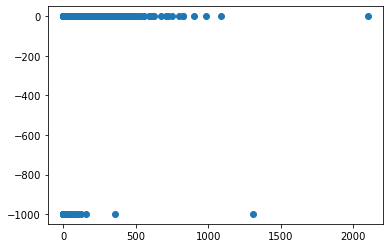

In [5]:
plt.scatter(T90[T90 > 0], Fluence[T90 > 0])

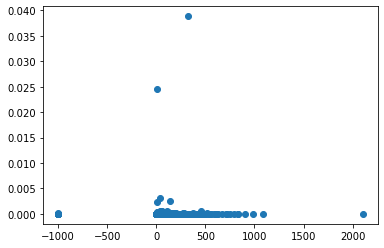

In [6]:
plt.scatter(T90[Fluence > 0], Fluence[Fluence > 0])

[]

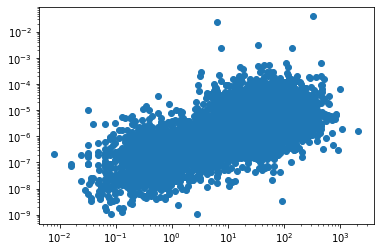

In [7]:
plt.scatter(T90[np.logical_and(T90 > 0, Fluence > 0)], Fluence[np.logical_and(T90 > 0, Fluence > 0)])
plt.loglog()

Logarithm

In [8]:
T90_ =  np.expand_dims(np.log10(T90[np.logical_and(T90 > 0, Fluence > 0)]), axis=1)
Fluence_ = np.expand_dims(np.log10(Fluence[np.logical_and(T90 > 0, Fluence > 0)]), axis=1)
print(Fluence_.shape)
print(T90_.shape)

(7239, 1)
(7239, 1)


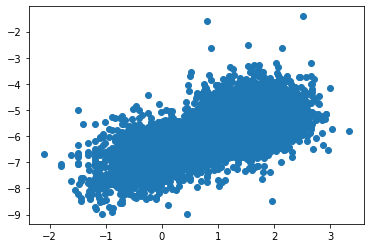

In [9]:
plt.scatter(T90_, Fluence_)


In [10]:
X = np.hstack((T90_,Fluence_))
print(X)

[[ 1.96334386 -5.09826386]
 [ 1.16411482 -5.15082637]
 [ 0.31132995 -6.24031705]
 ...
 [ 0.49637605 -7.60453382]
 [ 2.31926433 -6.78225293]
 [ 0.71466499 -5.58410892]]


I see two structures

Text(0, 0.5, 'Fluence')

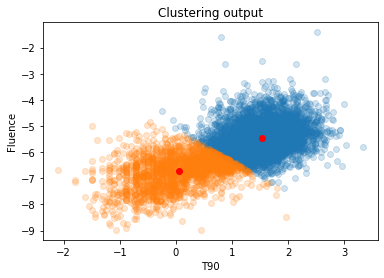

In [11]:
## from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0', 'C1']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], color=colors[ii],alpha=0.2)
    
plt.scatter(centers[:,0], centers[:,1], color = 'red')
# To get some information on these try:
# KMeans?
# help(clf)
plt.title('Clustering output');
plt.xlabel('T90')
plt.ylabel('Fluence')

In [12]:
print(centers)

[[ 1.52423553 -5.46662449]
 [ 0.05411913 -6.73455185]]


## Mean-shift Clustering

proviamo scartando

In [ ]:
### non stai togliendo punti
#Xr = X[X[:,1] < -3]
#print(X.shape)
#print(Xr.shape)

In [13]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth 

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

clf2 = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf2.fit(X_scaled)
centers_seed = clf2.cluster_centers_ #location of the clusters

bandwidth = 0.4
#bandwidth = estimate_bandwidth(X_scaled) 
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, seeds = centers_seed)

ms.fit(X_scaled)

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[ 0.49324491,  0.43208163],
       [-1.2822896 , -1.12328333]]))

In [14]:
print(ms.labels_)
print(ms.labels_.shape)
print(np.unique(ms.labels_))
print(np.unique(ms.labels_).shape)

[-1 -1 -1 ... -1 -1 -1]
(7239,)
[-1  0  1]
(3,)


In [15]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)


[-1  0  1]
0.4
number of estimated clusters : 2


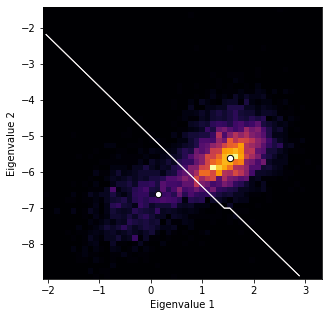

In [32]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='inferno')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='#faf5f5')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()